In [10]:
import pandas as pd

df = pd.read_csv("Data/taxi-fares.csv", parse_dates=['pickup_datetime'])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-06-15 17:11:00.000000107,7.0,2014-06-15 17:11:00+00:00,-73.995420,40.759662,-73.987607,40.751247,1
1,2011-03-14 22:43:00.00000095,4.9,2011-03-14 22:43:00+00:00,-73.993552,40.731110,-73.998497,40.737200,5
2,2011-02-14 15:14:00.00000067,6.1,2011-02-14 15:14:00+00:00,-73.972380,40.749527,-73.990638,40.745328,1
3,2009-10-29 11:29:00.00000040,6.9,2009-10-29 11:29:00+00:00,-73.973703,40.763542,-73.984253,40.758603,5
4,2011-07-02 10:38:00.00000028,10.5,2011-07-02 10:38:00+00:00,-73.921262,40.743615,-73.967383,40.765162,1


Tiền xử lý dữ liệu theo khoảng cách tọa độ và thứ ngày tháng

In [11]:
from math import sqrt

df = df[df['passenger_count'] == 1]
df = df.drop(['key', 'passenger_count'], axis=1)

for i, row in df.iterrows():
    dt = row['pickup_datetime']
    df.at[i, 'day_of_week'] = dt.weekday()
    df.at[i, 'pickup_time'] = dt.hour
    x = (row['dropoff_longitude'] - row['pickup_longitude']) * 54.6
    y = (row['dropoff_latitude'] - row['pickup_latitude']) * 69.0
    distance = sqrt(x**2 + y**2)
    df.at[i, 'distance'] = distance

df.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
         'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)

df = df[(df['distance'] > 1.0) & (df['distance'] < 10.0)]
df = df[(df['fare_amount'] > 0.0) & (df['fare_amount'] < 50.0)]
df.head()

,fare_amount,day_of_week,pickup_time,distance
2,6.1,0.0,15.0,1.038136
4,10.5,5.0,10.0,2.924341
5,15.3,4.0,20.0,4.862893
8,7.7,5.0,1.0,2.603493
9,8.9,3.0,16.0,1.365739


Tạo mạng có lớp đầu vào chấp nhận ba giá trị (ngày, giờ và khoảng cách), hai lớp ẩn với 512 nơ-ron mỗi lớp và một lớp đầu ra với một nơ-ron duy nhất (số tiền vé dự đoán)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(521, activation='relu', input_dim = 3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mae', metrics=['mae'])
model.summary()

c:\Users\Richard Nguyen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 521)            │         2,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,861 (1.03 MB)

 Trainable params: 269,861 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

Tiến hành huấn luyện mô hình mạng nơ ron

In [13]:
x = df.drop('fare_amount', axis=1)
y = df['fare_amount']

hist = model.fit(x, y, validation_split=0.2, epochs=100, batch_size=100)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0497 - mae: 4.0497 - val_loss: 2.5292 - val_mae: 2.5292
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4319 - mae: 2.4319 - val_loss: 2.3546 - val_mae: 2.3546
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4114 - mae: 2.4114 - val_loss: 2.3583 - val_mae: 2.3583
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3586 - mae: 2.3586 - val_loss: 2.3724 - val_mae: 2.3724
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3808 - mae: 2.3808 - val_loss: 2.3440 - val_mae: 2.3440
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3832 - mae: 2.3832 - val_loss: 2.3693 - val_mae: 2.3693
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3253 - mae: 2.3253 - val_loss: 2.3641 - val_mae: 2.3641
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3554 - mae: 2.3554 - val_loss: 2.3516 - val_mae: 2.3516
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

Vẽ biểu đồ thể hiện độ lệch giữa tập huấn luyện và tập xác thực

[]

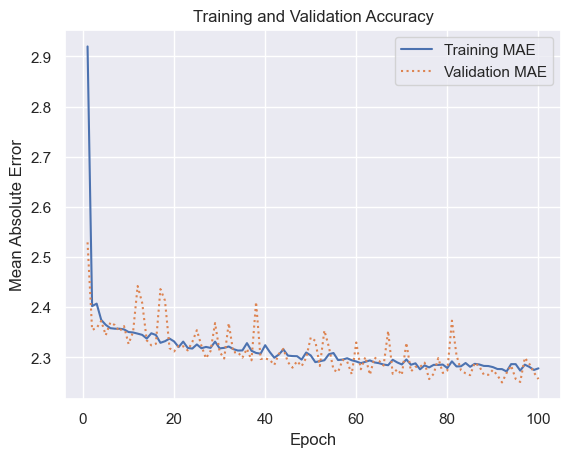

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set()

err = hist.history['mae']
val_err = hist.history['val_mae']
epochs = range(1, len(err) +1)

plt.plot(epochs, err, '-', label = 'Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

Sử dụng chỉ số R^2 để đo độ chính xác

In [15]:
from sklearn.metrics import r2_score

r2_score(y, model.predict(x))

729/729 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


0.7508441845250503

In [16]:
import numpy as np

model.predict(np.array([[4, 17, 2.0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[10.724738]], dtype=float32)